# Assignment 4

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as model
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize

In [2]:
types = pd.read_csv('types.csv', sep = ';')
codes = pd.read_csv('codes.csv', sep = ';')
transactions = pd.read_csv('transactions.csv', sep = ';')
train_set = pd.read_csv('train_set.csv', sep = ';')
test_set = pd.read_csv('test_set.csv', sep = ';')

# Descriptive Analysis

In [3]:
types.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
type,155.0,NaN,NaN,NaN,10819.045161,80000.258847,1000.0,2385.5,4040.0,7027.5,999999.0
type_description,155,139,н/д,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
codes.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
code,184.0,NaN,NaN,NaN,6046.793478,1470.328104,742.0,5208.25,5813.5,7283.0,9402.0
code_description,184,184,Поставщики грузовиков и запчастей,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
transactions.describe(include = 'all').T
# mean value of sum(-18129.1) is less than median value(-5502.49)
# also we have very big difference between max value and 75%tile, it means that most of our values are negative

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,130039.0,NaN,NaN,NaN,50868594.197495,28728539.409403,22899.0,25771743.0,52358368.0,75063019.0,99999680.0
datetime,130039,114770,456 00:00:00,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
code,130039.0,NaN,NaN,NaN,5594.629996,606.087084,742.0,5211.0,5641.0,6010.0,9402.0
type,130039.0,NaN,NaN,NaN,2489.372135,2253.296578,1000.0,1030.0,1110.0,2370.0,8145.0
sum,130039.0,NaN,NaN,NaN,-18129.093893,558444.522435,-41500301.14,-22449.16,-5502.49,-1122.96,67377473.16


In [6]:
df = pd.merge(pd.merge(transactions, types), codes)
df.head()

,client_id,datetime,code,type,sum,type_description,code_description
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
2,14331004,263 12:57:08,6011,2010,-3368873.66,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...


In [7]:
df.mode()

,client_id,datetime,code,type,sum,type_description,code_description
0,70780820,456 00:00:00,6011,1010,-2245.92,Покупка. POS,Финансовые институты — снятие наличности автом...


In [8]:
print('Range:', max(transactions['sum']) - min(transactions['sum'])) # Measures of spread
print('IQR:', transactions['sum'].quantile(0.75) - transactions['sum'].quantile(0.25))
print('Variance:', transactions['sum'].var())
print('Standart deviation:',  transactions['sum'].std())

Range: 108877774.3
IQR: 21326.2
Variance: 311860284637.53296
Standart deviation: 558444.5224348905


# Explanatory Data Analysis

In [9]:
df.shape
# Dataset comprises of 129998 observations and 7 characteristics

(129998, 7)

In [10]:
df.columns

Index(['client_id', 'datetime', 'code', 'type', 'sum', 'type_description',
       'code_description'],
      dtype='object')

In [11]:
df.nunique() # number of unique values for every column

client_id             8656
datetime            114752
code                   175
type                    63
sum                  27446
type_description        57
code_description       175
dtype: int64

In [12]:
df.info()
# our data have integer, float and object values, object values used for datetime and text in type, code descriptions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129998 entries, 0 to 129997
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         129998 non-null  int64  
 1   datetime          129998 non-null  object 
 2   code              129998 non-null  int64  
 3   type              129998 non-null  int64  
 4   sum               129998 non-null  float64
 5   type_description  129998 non-null  object 
 6   code_description  129998 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 7.9+ MB


In [13]:
df.isna().any()
# as we can see we have no null/missing values, so we dont need to delete them

client_id           False
datetime            False
code                False
type                False
sum                 False
type_description    False
code_description    False
dtype: bool

In [14]:
clients = np.array(df['client_id'].unique())
len(clients) # number of unique clients

8656

In [15]:
df.drop_duplicates(inplace = True)
df.shape 
# shape of dataframe before deleting dublicates = (129998, 7)
# 129998-129969 = 29 rows was deleted

(129969, 7)

In [16]:
df_sales = df.loc[df.type.isin([1000, 1100, 1110, 1010, 1210, 1200])]
df_sales # dataframe consist only sales type of transactions

,client_id,datetime,code,type,sum,type_description,code_description
46278,90641486,175 15:29:58,4814,1110,-3279.04,Покупка. POS,"Звонки с использованием телефонов, считывающих..."
46279,45885513,291 08:44:26,4814,1110,-15496.82,Покупка. POS,"Звонки с использованием телефонов, считывающих..."
46280,95394912,325 00:00:00,4814,1110,-27849.36,Покупка. POS,"Звонки с использованием телефонов, считывающих..."
46281,89637426,335 07:59:09,4814,1110,-10960.07,Покупка. POS,"Звонки с использованием телефонов, считывающих..."
46282,84199917,379 00:00:00,4814,1110,-4581.67,Покупка. POS,"Звонки с использованием телефонов, считывающих..."
...,...,...,...,...,...,...,...
129993,51907756,136 00:00:00,4131,1200,-146433.71,Покупка. Зарубеж.,Автобусные линии
129994,61978280,401 00:00:00,5169,1200,-271194.78,Покупка. Зарубеж.,"Химикалии и смежные вещества, не классифициров..."
129995,97803699,371 19:47:00,6513,1210,-60792.00,Покупка. POS Зарубеж.,Агенты и менеджеры по аренде недвижимости
129996,63953233,15 00:00:00,4411,1210,-77535.30,Покупка. POS Зарубеж.,Круизные линии


In [17]:
df_sum_positive = df[df['sum'] > 0]
df_sum_positive.head() # positive sum of transactions

,client_id,datetime,code,type,sum,type_description,code_description
15758,69189450,389 00:00:00,6011,2010,44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
20204,24567813,377 17:20:40,6011,7010,67377.47,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
20205,82840746,454 18:49:24,6011,7010,134754.95,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
20206,74334566,187 16:36:30,6011,7010,134754.95,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
20207,49760703,94 18:56:40,6011,7010,22459.16,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...


In [18]:
df_sum_negative = df[df['sum'] < 0]
df_sum_negative.head() # negative sum of transactions

,client_id,datetime,code,type,sum,type_description,code_description
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
2,14331004,263 12:57:08,6011,2010,-3368873.66,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...


# Visualizations

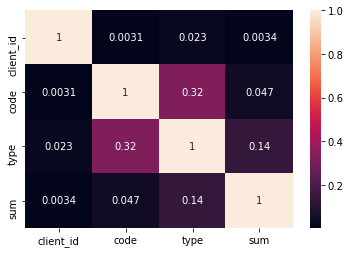

In [19]:
# Realtionship analysis based on correlation matrix
correlation = df.corr()
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, annot = True)
plt.show()
# the higher correlation coefficient between type and code 
# type of transaction has the greatest influence on sum

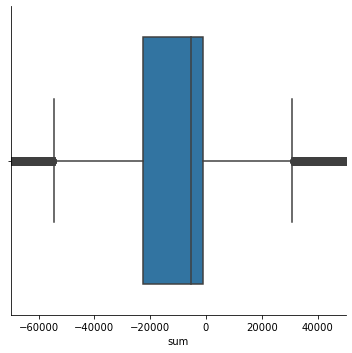

In [20]:
# box plot
sns.catplot(x = 'sum', kind = 'box', data = df)
plt.xlim(-70000, 50000)
plt.show()

<AxesSubplot:>

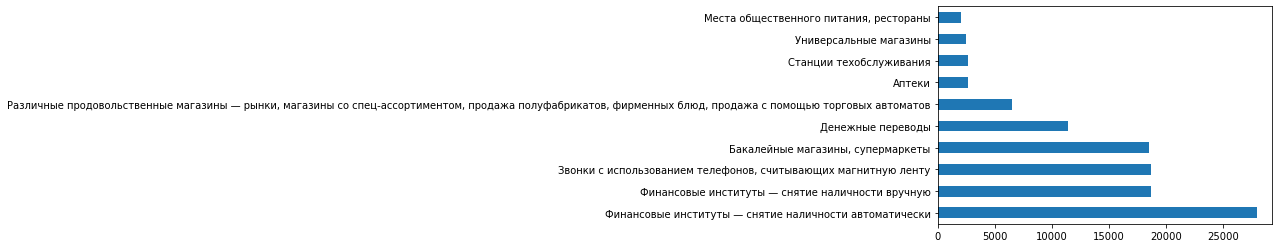

In [21]:
# graphs show Top 10 codes of transactions
df['code_description'].value_counts()[0:10].plot.barh()

<AxesSubplot:>

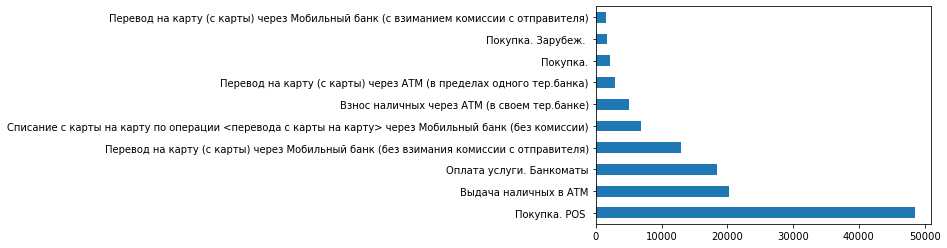

In [22]:
# graphs show Top 10 types of transactions
df['type_description'].value_counts()[0:10].plot.barh()

# Feature engineering and Data cleaning

In [23]:
# divide datetime column to date and time columns
df[['day', 'time']] = df['datetime'].str.split(' ', expand = True)
df[['hour', 'minute','second']] = df['time'].str.split(':', expand=True)

In [24]:
df.head()

,client_id,datetime,code,type,sum,type_description,code_description,day,time,hour,minute,second
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,421,06:33:15,06,33,15
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,55,13:38:47,13,38,47
2,14331004,263 12:57:08,6011,2010,-3368873.66,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,263,12:57:08,12,57,08
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,355,09:47:45,09,47,45
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,184,20:09:07,20,09,07


In [25]:
# change types of columns to int
df = df.astype({'day': int})
df = df.astype({'hour': int})
df = df.astype({'minute': int})
df = df.astype({'second': int})

In [26]:
df['day'].max() # find number of dates in database

456

In [27]:
date = datetime.datetime(2021, 1, 1) # start date is 1 january of 2021
step = datetime.timedelta(days = 1)
dates = {} # dictionary will store the serial number of the date and date
date_list = []
for i in range(0, 457):
    dates[i] = date.strftime('%Y-%m-%d')
    date += step
    
for i in df['day']:
    date_list.append(dates[i])
#new column date
df['date'] = date_list
df

,client_id,datetime,code,type,sum,type_description,code_description,day,time,hour,minute,second,date
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,421,06:33:15,6,33,15,2022-02-26
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,55,13:38:47,13,38,47,2021-02-25
2,14331004,263 12:57:08,6011,2010,-3368873.66,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,263,12:57:08,12,57,8,2021-09-21
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,355,09:47:45,9,47,45,2021-12-22
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,184,20:09:07,20,9,7,2021-07-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129993,51907756,136 00:00:00,4131,1200,-146433.71,Покупка. Зарубеж.,Автобусные линии,136,00:00:00,0,0,0,2021-05-17
129994,61978280,401 00:00:00,5169,1200,-271194.78,Покупка. Зарубеж.,"Химикалии и смежные вещества, не классифициров...",401,00:00:00,0,0,0,2022-02-06
129995,97803699,371 19:47:00,6513,1210,-60792.00,Покупка. POS Зарубеж.,Агенты и менеджеры по аренде недвижимости,371,19:47:00,19,47,0,2022-01-07
129996,63953233,15 00:00:00,4411,1210,-77535.30,Покупка. POS Зарубеж.,Круизные линии,15,00:00:00,0,0,0,2021-01-16


In [28]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 23):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [29]:
# new column sessions
df['sessions'] = df['hour'].apply(f)
df

,client_id,datetime,code,type,sum,type_description,code_description,day,time,hour,minute,second,date,sessions
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,421,06:33:15,6,33,15,2022-02-26,Early Morning
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,55,13:38:47,13,38,47,2021-02-25,Noon
2,14331004,263 12:57:08,6011,2010,-3368873.66,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,263,12:57:08,12,57,8,2021-09-21,Morning
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,355,09:47:45,9,47,45,2021-12-22,Morning
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,184,20:09:07,20,9,7,2021-07-04,Eve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129993,51907756,136 00:00:00,4131,1200,-146433.71,Покупка. Зарубеж.,Автобусные линии,136,00:00:00,0,0,0,2021-05-17,Late Night
129994,61978280,401 00:00:00,5169,1200,-271194.78,Покупка. Зарубеж.,"Химикалии и смежные вещества, не классифициров...",401,00:00:00,0,0,0,2022-02-06,Late Night
129995,97803699,371 19:47:00,6513,1210,-60792.00,Покупка. POS Зарубеж.,Агенты и менеджеры по аренде недвижимости,371,19:47:00,19,47,0,2022-01-07,Eve
129996,63953233,15 00:00:00,4411,1210,-77535.30,Покупка. POS Зарубеж.,Круизные линии,15,00:00:00,0,0,0,2021-01-16,Late Night


Having studied the data set, we found out that there are still rows in the types that do not carry informational significance, namely, there were several rows without a description.

In [30]:
types.loc[types['type_description'].isin(['н/д(нет данных)','н/д']),['type_description']] = np.nan
types.head()

,type,type_description
0,8001,Установление расх. лимита по карте
1,2411,Перевод с карты на счет др.лица в одном тер. б...
2,4035,NaN
3,3001,Комиссия за обслуживание ссудного счета
4,2420,Перевод с карты на счет физ.лица в другом тер....


In [31]:
# setting monetary
transcactions_sum = transactions.groupby('client_id').sum().drop(columns = ['code','type'])
# setting frequency
transcactions_count = aggregated_1 = transactions.groupby('client_id').count().drop(columns = ['code','type', 'datetime']).rename(columns={'sum': 'count_transactions'})
transcactions_sum_count = pd.concat([transcactions_sum, transcactions_count], axis=1, join = 'outer')
transcactions_sum_count.head()

,sum,count_transactions
client_id,,
22899,50847.54,9
27914,74115.21,4
28753,-2589800.29,13
31385,-83525.38,13
38084,693495.66,26


In [32]:
#scoring functions  
def FMScore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [33]:
fm_table = transcactions_sum_count
quantiles = fm_table.quantile(q = [0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()
#setting score
# calculate frequence and monetary quantiles
fm_table['f_quartile'] = fm_table['count_transactions'].apply(FMScore, args = ('count_transactions', quantiles,))
fm_table['m_quartile'] = fm_table['sum'].apply(FMScore, args = ('sum', quantiles,))
fm_table.head()

,sum,count_transactions,f_quartile,m_quartile
client_id,,,,
22899,50847.54,9,3,1
27914,74115.21,4,4,1
28753,-2589800.29,13,2,4
31385,-83525.38,13,2,2
38084,693495.66,26,1,1


In [34]:
time = transactions.drop(columns = ['code', 'type'])
time['day_number'] = transactions['datetime'].str[:3]
time['time'] = transactions['datetime'].str[-8:].str[:2]
time['time'] = time['time'].astype(int)
time.head()

,client_id,datetime,sum,day_number,time
0,96372458,421 06:33:15,-561478.94,421,6
1,24567813,377 17:20:40,67377.47,377,17
2,21717441,55 13:38:47,-44918.32,55,13
3,14331004,263 12:57:08,-3368873.66,263,12
4,85302434,151 10:34:12,-3368.87,151,10


In [35]:
# finding the type and code mode for each client
buffer = transactions.groupby('client_id').agg({'code': lambda x: x.value_counts().index[0], 'type': lambda x: x.value_counts().index[0]})
predictors = pd.concat([transcactions_sum_count, buffer], axis = 1, join = 'outer')
predictors = predictors.rename(columns = {'sum': 'sum_of_transactions', 'code': 'Code_mode', 'type': 'Type_mode'})
# change type of columns
predictors['Code_mode'] = predictors['Code_mode'].astype('category')
predictors['Type_mode'] = predictors['Type_mode'].astype('category')
buffer = time.drop(columns = ['sum', 'day_number', 'datetime']).groupby('client_id').mean()
# rename columns
buffer = buffer.rename(columns = {'time': 'hour_mean'})
# merge datasets
predictors = pd.merge(predictors, buffer, on = 'client_id', how = 'left')
train_set = pd.merge(train_set, predictors, on = 'client_id', how = 'left')
predictors.head()

,sum_of_transactions,count_transactions,f_quartile,m_quartile,Code_mode,Type_mode,hour_mean
client_id,,,,,,,
22899,50847.54,9,3,1,6011,4010,13.555556
27914,74115.21,4,4,1,4814,1030,12.250000
28753,-2589800.29,13,2,4,4814,1010,7.000000
31385,-83525.38,13,2,2,5411,1030,14.538462
38084,693495.66,26,1,1,6011,1010,13.000000


In [36]:
# calculating positive, negative and eman transactions
train_set['Transactions_tendency'] = '0'
train_set.loc[train_set['sum_of_transactions'] > 0, 'Transactions_tendency'] = '+'
train_set.loc[train_set['sum_of_transactions'] < 0, 'Transactions_tendency'] = '-'
train_set['Transaction_mean'] = train_set['sum_of_transactions'] / train_set['count_transactions']
train_set.head()

,client_id,target,sum_of_transactions,count_transactions,f_quartile,m_quartile,Code_mode,Type_mode,hour_mean,Transactions_tendency,Transaction_mean
0,75063019,0,89032.60,29,1,1,6011,1010,15.068966,+,3070.089655
1,86227647,1,-606058.60,27,1,4,6011,1030,11.222222,-,-22446.614815
2,6506523,0,2635753.74,53,1,1,6010,7070,13.735849,+,49731.202642
3,50615998,0,-42672.40,7,3,2,4814,1030,14.142857,-,-6096.057143
4,95213230,0,214292.66,34,1,1,4814,1030,9.617647,+,6302.725294


# Unsupervised learning. Cluster analysis.

### K-means clustering

In [37]:
X = df[['code', 'sum', 'type']]
X

,code,sum,type
0,6011,-561478.94,2010
1,6011,-44918.32,2010
2,6011,-3368873.66,2010
3,6011,-65131.56,2010
4,6011,-224591.58,2010
...,...,...,...
129993,4131,-146433.71,1200
129994,5169,-271194.78,1200
129995,6513,-60792.00,1210
129996,4411,-77535.30,1210


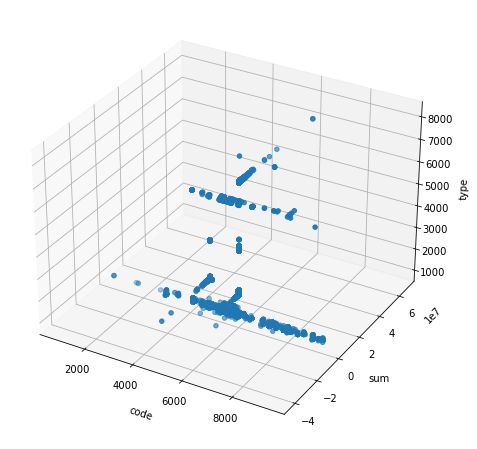

In [38]:
fig = plt.figure(figsize = (10, 8))
ax = plt.axes(projection = '3d')
# plot 3d graph
ax.scatter3D(X.loc[:, 'code'], X.loc[:, 'sum'], X.loc[:, 'type'])
# det labels
ax.set_xlabel('\ncode')
ax.set_ylabel('\nsum')
ax.set_zlabel('\ntype')
plt.show()

In [39]:
kmeans = KMeans(n_clusters = 4) 
kmeans.fit(X)
X1 = X
# show dataset with ading class values
X1['Class'] = kmeans.labels_
X1

<ipython-input-39-f77a5f22bd9c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1['Class'] = kmeans.labels_


,code,sum,type,Class
0,6011,-561478.94,2010,0
1,6011,-44918.32,2010,0
2,6011,-3368873.66,2010,3
3,6011,-65131.56,2010,0
4,6011,-224591.58,2010,0
...,...,...,...,...
129993,4131,-146433.71,1200,0
129994,5169,-271194.78,1200,0
129995,6513,-60792.00,1210,0
129996,4411,-77535.30,1210,0


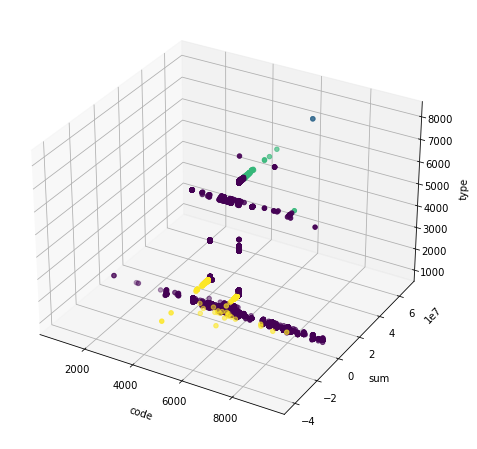

In [40]:
fig = plt.figure(figsize = (10, 8))

ax = plt.axes(projection = '3d')

ax.scatter3D(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c = kmeans.labels_)
#ax.scatter3D(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = [0, 1, 2, 3], linewidth = 5)
ax.set_xlabel('\ncode')
ax.set_ylabel('\nsum')
ax.set_zlabel('\ntype')
plt.show()

In [41]:
# do the same thing for 2 classes
kmeans = KMeans(n_clusters = 2) 
kmeans.fit(X)
X1 = X
X1['Class'] = kmeans.labels_
X1

<ipython-input-41-bfeb24fc2022>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1['Class'] = kmeans.labels_


,code,sum,type,Class
0,6011,-561478.94,2010,0
1,6011,-44918.32,2010,0
2,6011,-3368873.66,2010,0
3,6011,-65131.56,2010,0
4,6011,-224591.58,2010,0
...,...,...,...,...
129993,4131,-146433.71,1200,0
129994,5169,-271194.78,1200,0
129995,6513,-60792.00,1210,0
129996,4411,-77535.30,1210,0


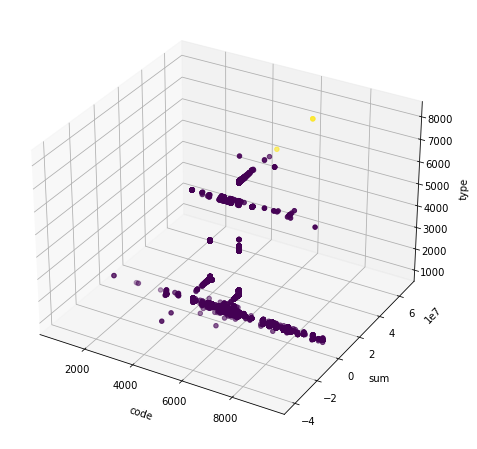

In [42]:
fig = plt.figure(figsize = (10, 8))

ax = plt.axes(projection = '3d')

ax.scatter3D(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c = kmeans.labels_)
#ax.scatter3D(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = [0, 1, 2, 3], linewidth = 5)
ax.set_xlabel('\ncode')
ax.set_ylabel('\nsum')
ax.set_zlabel('\ntype')
plt.show()

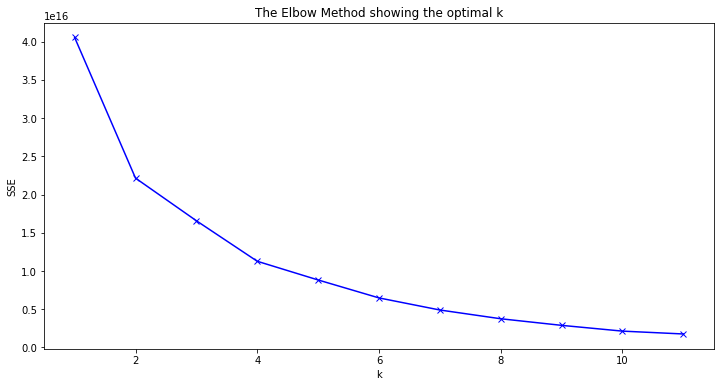

In [43]:
SSE = []

for k in range(1, 12):
    kmeans = KMeans(n_clusters = k) 
    kmeans.fit(X)
    # calculating the values of the Inertia
    SSE.append(kmeans.inertia_)
plt.figure(figsize = (12, 6))
plt.plot(range(1, 12), SSE, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()
##best k = 4

To determine the optimal number of clusters, we choose the value of k at the "elbow", that is, at the point after which the distortion/inertia begins to decrease linearly. So for the given data, we conclude that the optimal number of clusters for the data is 4.

# Hierarchical clustering

In [44]:
df_work = df[['sum', 'code', 'type']]
# первично мы очистили наш dataframe от ненужных колонок чтобы не отвлекали и не занимали место и память
# мы выбрали 'sum','code','type' 
df_work = df_work.drop_duplicates() 
# тут мы убераем дубликаты потому что для класстеризаций будликаты не несут ценности а наоборот сбивают с толку(очистка данных)
df_work.index = pd.RangeIndex(len(df_work.index))
df_work.index = range(len(df_work.index))
# обычная переиндексация для удобства и визуального удовлетворения
df_work

,sum,code,type
0,-561478.94,6011,2010
1,-44918.32,6011,2010
2,-3368873.66,6011,2010
3,-65131.56,6011,2010
4,-224591.58,6011,2010
...,...,...,...
50215,-146433.71,4131,1200
50216,-271194.78,5169,1200
50217,-60792.00,6513,1210
50218,-77535.30,4411,1210


In [45]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(df_work)
# стандартизация это метод масштабирования, при котором данные не масштабируются 
# путем преобразования статистического распределения данных это используется когда 
# данные содержат в совокупности признаки разного размера и масштаба. 
# Различные масштабы функций данных отрицательно влияют на моделирование набора данных.
# Вот тут-то и появляется стандартизация.
# Особенность стандартизаций в том что она весь набор данных масштабируется вместе с нулевым значением и единичной дисперсией.
# z-преобразование
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
# normalization is a procedure of preprocessing of input information(training,test and validation samples,as well as real data)
# in which values of features in the input vector are reduced to a certain given range
# for example, [0...1] or [-1...1]

# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df)

  
# Reducing the dimensions of the data
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
# Principal component analysis (PCA). L
# inear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. 
# The input data is centered but not scaled for each feature before applying the SVD.

X_principal

,P1,P2
0,0.640703,-0.377627
1,0.884476,-0.761129
2,0.422282,0.002127
3,0.879708,-0.756491
4,0.805251,-0.648976
...,...,...
50215,-0.300364,0.818826
50216,-0.416985,0.508742
50217,0.709206,-0.840211
50218,-0.325732,0.796079


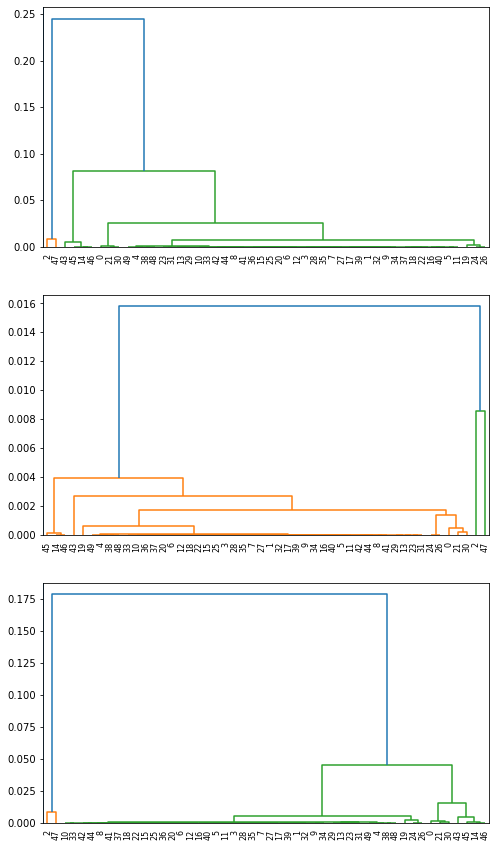

In [46]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3, 1)
fig = plt.figure(figsize = (8, 15))

ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1.plot([0,1])
model.dendrogram((model.linkage(X_principal[:50], method ='complete', metric = 'cosine')))

ax2 = fig.add_subplot(gs[1, 0]) # row 0, col 1
ax2.plot([0,1])
model.dendrogram((model.linkage(X_principal[:50], method ='single', metric = 'cosine')))

ax3 = fig.add_subplot(gs[2, 0]) # row 1, span all columns
ax3.plot([0,1])
model.dendrogram((model.linkage(X_principal[:50], method ='average', metric = 'cosine')))

plt.show()

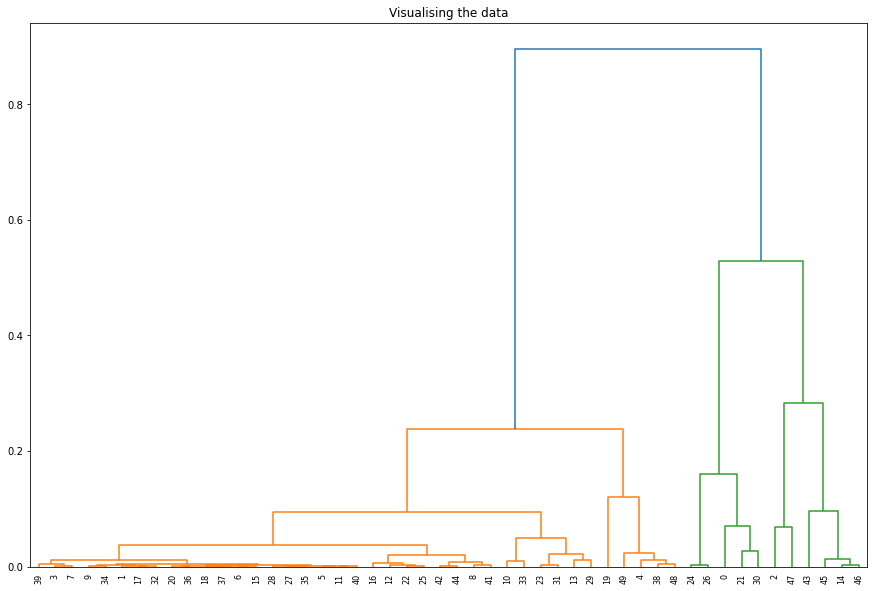

In [56]:
# тут мы строим дендаграмму с различными  linkages
plt.figure(figsize =(15, 10)) 
plt.title('Visualising the data') 
Dendrogram = model.dendrogram((model.linkage(X_principal[:50], method ='complete',metric='euclidean'))) 
# Dendrogram = model.dendrogram((model.linkage(X_principal[:50], method ='complete',metric='minkowski'))) 
# Dendrogram = model.dendrogram((model.linkage(X_principal[:50], method ='complete',metric='cityblock'))) 
# Dendrogram = model.dendrogram((model.linkage(X_principal[:50], method ='complete',metric='seuclidean'))) 
# Dendrogram = model.dendrogram((model.linkage(X_principal[:50], method ='complete',metric='cosine')))
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#:~:text=Computes%20the%20distance%20between%20m,'%2C%20p%3D2.)
# ссылка на другие метрики

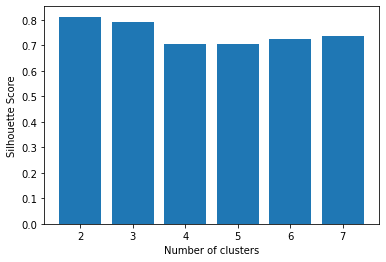

In [48]:
silhouette_scores = [] 

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(X_principal[:50], AgglomerativeClustering(n_clusters = n_cluster).fit_predict(X_principal[:50]))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6,7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

In [49]:
agg = AgglomerativeClustering(n_clusters=4)
agg.fit(X_principal[:50])

AgglomerativeClustering(n_clusters=4)

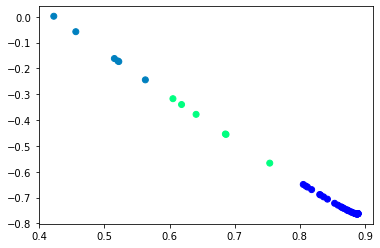

In [50]:
plt.scatter(X_principal['P1'][:50], X_principal['P2'][:50],
            c = AgglomerativeClustering(n_clusters = 3).fit_predict(X_principal[:50]), cmap =plt.cm.winter) 
plt.show()

# Analysis

1. We can see from the data visualization analysis that the transaction code "financial institution - manual withdrawal" appears the most in the transaction data. The highest number of transaction code descriptions were "Calls Using a Recorded Phone," "Grocery Stores, Supermarkets," and "Financial Institutions - Manual Withdrawals," all of which had similar numbers.
2. If we talk about the types of transactions, then most often we met "Purchase. Foreign POS." .
3. By evaluating the correlation between the values in our database, we can conclude that the values among themselves have a low correlation, which indicates a weak relationship. At the same time, the largest correlation coefficient was found between the type and transaction code.
4. If we talk about the amount of the transaction, then it has too much difference, since it includes both negative and positive values   (depending on the operation), therefore they have a huge number of deviations
5. Based on 2 different clustering methods, we came to the same result that the optimal number of clusters is 4
6. Graphics of clusterizations shows that the most common transaction code for customers is 6000 (described as "Financial Institution - Manual Withdrawal"), and the most common transaction type is 1500. (described as "Purchase. Foreign POS").

# Conclusion

1. We have started to analyze with raw data. Where we begin with merging in transaction type. Also, in descriptive analysis our group identified information about our dataset. Evaluated on sales type of transactions where visualized by using graphs. Focused on sum and sales type by organizing time of dataframe. In feature engineering we started to group inside dataset by using function in order to make distribution of time.
2. We note that the construction of signs is a working technique for solving the problem, which allowed us to equalize the quality of the algorithm we developed, for example, in showing positive and negative transactions, we were able to get a complete result
3. Hierarchical clustering is a powerful technique that allows you to build tree structures based on data similarity. You can see how the different subclusters are related to each other and how far apart the data points are.
4. Talking about k-means clustering gives us the ability to build a three-dimensional graph and show the relationship between all three variables taken